In [1]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from numpy.fft import rfft, irfft, fft, ifft, fftfreq, rfftfreq

In [2]:
n = 1000
L = 4000
noise_traces = np.random.normal(size=(n,L))

In [3]:
template = np.concatenate((np.zeros(1000), 3000-np.arange(3000)))/3000

In [4]:
true_amplitudes = np.random.uniform(5,10,size=n)

In [5]:
traces = noise_traces + true_amplitudes[:,None]*np.concatenate((template[3:], np.zeros(3)))[None,:]

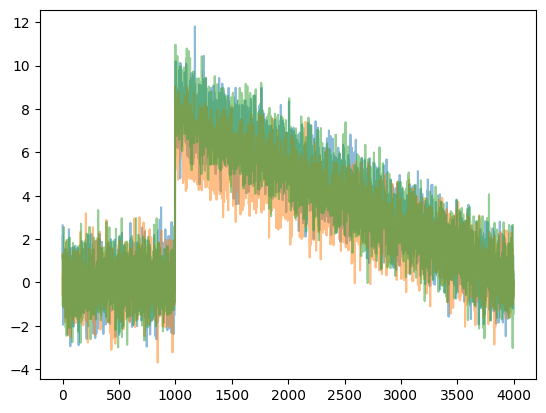

In [12]:
for i in range(3):
    plt.plot(traces[i], alpha=0.5)
plt.show()

In [7]:
#noise_psd = np.ones(L//2+1)

freq, noise_fft = signal.periodogram(noise_traces, fs=1e6)
noise_psd = np.mean(noise_fft, axis=0)

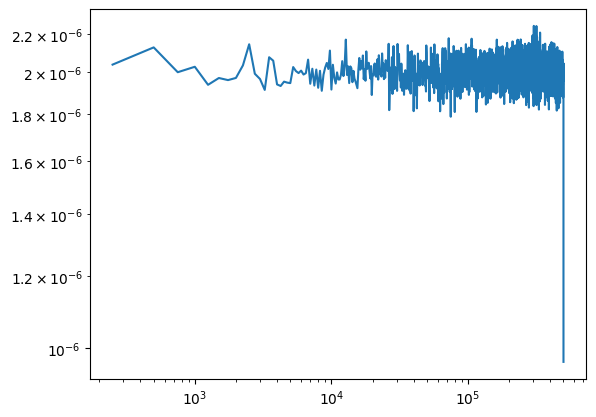

In [8]:
plt.loglog(freq[1:], noise_psd[1:])
plt.show()

In [9]:
f, noise_psd = calc_psd(noise_traces, 1e6, True)

NameError: name 'calc_psd' is not defined

In [392]:
class OptimumFilter():
    
    def __init__(self, template, noise_psd, sampling_frequency):
        self._template = template
        self._noise_psd = noise_psd
        self._sampling_frequency = sampling_frequency
        self._update_state()
        
    def set_template(self, template):
        self._template = template
        self._update_state()
        
    def set_noise_psd(self, noise_psd):
        self._noise_psd = noise_psd
        self._update_state()
        
    def _update_state(self):
        self._length = len(self._template)
        
        if self._length%2==0:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:-1]/2,
                                                       [self._noise_psd[-1]],
                                                       self._noise_psd[-2:0:-1]/2))
        else:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:]/2,
                                                       self._noise_psd[-1:0:-1]/2))
            
        
        self._template_fft = fft(self._template)/self._sampling_frequency
        
        self._kernel_fft = self._template_fft.conjugate() / self._noise_psd_unfolded
        self._kernel_normalization = np.real(np.dot(self._kernel_fft, self._template_fft))*self._sampling_frequency/self._length 
        
    def fit(self, trace):

        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._kernel_fft * trace_fft / self._kernel_normalization # Phi * V
        
        chisq0 = np.real(
            np.dot(trace_fft.conjugate()/self._noise_psd_unfolded,
                   trace_fft)*self._sampling_frequency/self._length
        )
        
        
        amp0 = np.real(np.sum(
            trace_filtered, axis=-1
        ))*self._sampling_frequency/self._length


        # total chisq
        # self._length-2 is the assumed number of degrees of freedom
        chisq = (chisq0 - (amp0**2)*self._kernel_normalization)/(self._length-2)
        
        return amp0, chisq
    
    def fit_with_shift(self, trace, allowed_shift_range=None):
 
        
        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._kernel_fft * trace_fft / self._kernel_normalization # Phi * V
        trace_filtered_td = np.real(
            ifft(trace_filtered, axis=-1)
        ) * self._sampling_frequency

        chi0 = np.real(
            np.dot(trace_fft.conjugate()/self._noise_psd_unfolded,
                   trace_fft)*self._sampling_frequency/self._length
        )

        chit_withdelay = (trace_filtered_td**2) * self._kernel_normalization
        chi = chi0 - chit_withdelay
        
        if allowed_shift_range is None:
            ind = np.arange(len(chi))
        else:
            ind = np.concatenate((np.arange(self._length+allowed_shift_range[0], self._length),
                                  np.arange(allowed_shift_range[1]+1)))
        
        best_ind = ind[np.argmin(chi[ind], axis=-1)]
        
        amp = trace_filtered_td[best_ind]
        chisq = chi[best_ind]/(self._length-3)
        t0 = best_ind if best_ind<self._length//2 else best_ind-self._length
        
        return amp, chisq, t0

In [393]:
of = OptimumFilter(template, noise_psd, 1e6)

In [394]:
np.array([of.fit(t) for t in traces]).shape

(1000, 2)

In [395]:
print(of.fit_with_shift(traces[0], allowed_shift_range=(-20,20)))
print(of.fit(traces[0]))

(7.162379995686423, 1.0366335995949716, -3)
(7.132447547411335, 1.082395857933444)


In [397]:
np.load('../../processor/data/template.npy').shape

(32768,)

In [399]:
noise_traces.shape

(1000, 4000)

In [400]:
f, noise_psd = calc_psd(np.random.normal(size=(1000,32768)), 1, True)

In [403]:
np.save('../../processor/data/psd.npy', noise_psd)

In [379]:
of_results = [ of.fit_with_delay(t, allowed_shift_range=(-3,3)) for t in traces[:5] ]
amplitudes = np.array([r[0] for r in of_results])
chisqs = np.array([r[1] for r in of_results])
t0s = np.array([r[2] for r in of_results])

[3997 3998 3999    0    1    2    3]
0
3997
[3997 3998 3999    0    1    2    3]
0
3997
[3997 3998 3999    0    1    2    3]
0
3997
[3997 3998 3999    0    1    2    3]
0
3997
[3997 3998 3999    0    1    2    3]
0
3997


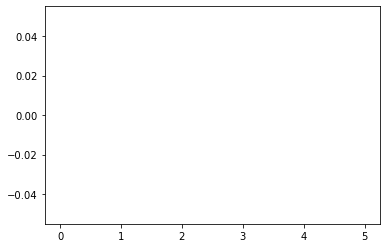

[-3 -3 -3]


In [380]:
plt.hist(t0s, bins=np.arange(6))
plt.show()
print(t0s[:3])

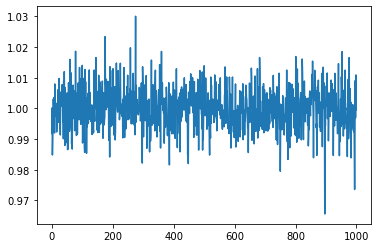

In [101]:
plt.plot(amplitudes/true_amplitudes)

In [102]:
chisqs = np.array([r[1] for r in of_results])

In [103]:
chisqs.mean(), chisqs.std()

(4000.9639408128605, 89.56120662690576)

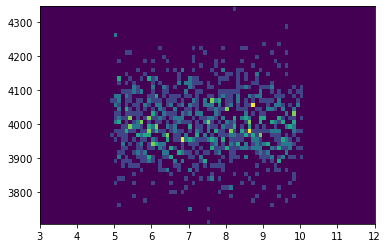

In [104]:
plt.hist2d(amplitudes, chisqs, bins=(np.linspace(3,12,91), np.linspace(np.min(chisqs),np.max(chisqs),51)))
plt.show()

In [93]:
chisqs_full = chisqs
ampl_full = amplitudes

In [35]:
amplitudes[:100]

array([ 8.28775392,  8.29594527,  8.3409064 ,  7.11640602,  9.36693782,
        9.30024843,  9.56412738,  7.4597623 ,  8.47079877,  8.06182338,
       10.0378079 ,  8.88179428,  7.49368671,  9.17823401,  6.72925265,
        9.71848025,  8.02891991,  7.16864762,  8.28718756,  9.61142953,
        5.71868301,  8.59817632,  6.73498717,  8.57593602,  7.69166877,
        6.64550868,  5.62081686,  8.51181937,  7.68956041,  7.67103721,
        6.15554171,  5.95830032,  8.16869848,  6.05366207,  5.81484561,
        6.60702443,  6.44754586,  6.01097502,  8.60505284, 10.04833954,
        9.43059665,  7.45949752,  6.44108711,  5.10460079,  7.96099927,
        7.86070268,  7.72814175,  8.5489317 ,  5.28975299,  6.3675124 ,
        6.35097045,  8.49521483,  7.76504001,  6.24049579,  5.05679787,
        9.3347974 ,  5.99328353,  5.13768131,  9.57975004,  9.10047339,
        8.5349045 ,  7.70239092,  7.7777038 ,  7.05153373,  8.40652918,
        7.18273423,  8.16756457,  5.25872614,  9.10540319,  5.26

In [11]:
import qetpy

/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-08/lib/python3.7/site-packages/astropy/version.py:26: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  for j, piece in enumerate(LooseVersion(version).version[:3]):
/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-08/lib/python3.7/site-packages/astropy/utils/introspection.py:160: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(have_version) >= LooseVersion(version)
/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-08/lib/python3.7/site-packages/dask/compatibility.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PY_VERSION = LooseVersion(".".join(map(str, sys.version_info[:3])))
/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-08/lib/python3.7/site-packages/dask/array/numpy_compat.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging

In [160]:
of = qetpy.OptimumFilter(traces[0], template, noise_psd_2, 1e6)

for i in range(3):
    of.update_signal(traces[i])
    print(of.ofamp_nodelay())
    print(of.ofamp_withdelay())

(8.285217532962578, 4006.609225212993)
(8.28521753296258, 0.0, 4006.609225212982)
(8.347016924555733, 4066.0883760547913)
(8.347016924555732, 0.0, 4066.088376054806)
(8.267543383933377, 4024.961780390924)
(8.267543383933376, 0.0, 4024.9617803909387)
